In [1]:
# Core libs
import logging
from neo4j import GraphDatabase
import pandas as pd
import numpy as np

from itertools import combinations
from numpy.linalg import norm

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# Load env vars
from dotenv import load_dotenv
import os

# Set the logging level for the 'neo4j' module to ERROR
logging.getLogger("neo4j").setLevel(logging.ERROR)

load_dotenv()
# Neo4j connection details
URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
USER = os.getenv("NEO4J_USER", "neo4j")
PASSWORD = os.getenv("NEO4J_PASSWORD", "password")
DATABASE = os.getenv("NEO4J_DATABASE", "stocks")

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

def run_cypher(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a Cypher query and return a pandas DataFrame."""
    with driver.session(database=DATABASE) as session:
        result = session.run(query, params or {})
        return pd.DataFrame([r.data() for r in result])


In [2]:
# Get all windows with their start/end dates
df_windows = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       min(r.start) AS start,
       max(r.end)   AS end
ORDER BY start
""")

df_windows["start"] = pd.to_datetime(df_windows["start"].astype(str))
df_windows["end"]   = pd.to_datetime(df_windows["end"].astype(str))

df_windows


,window_id,start,end
0,W_20180102_20180123,2018-01-02,2018-01-23
1,W_20180105_20180126,2018-01-05,2018-01-26
2,W_20180110_20180131,2018-01-10,2018-01-31
3,W_20180116_20180205,2018-01-16,2018-02-05
4,W_20180119_20180208,2018-01-19,2018-02-08
...,...,...,...
654,W_20251022_20251111,2025-10-22,2025-11-11
655,W_20251027_20251114,2025-10-27,2025-11-14
656,W_20251030_20251119,2025-10-30,2025-11-19
657,W_20251104_20251124,2025-11-04,2025-11-24


In [3]:
# Sorted list of window_ids
window_ids = df_windows["window_id"].tolist()
window_ids


['W_20180102_20180123',
 'W_20180105_20180126',
 'W_20180110_20180131',
 'W_20180116_20180205',
 'W_20180119_20180208',
 'W_20180124_20180213',
 'W_20180129_20180216',
 'W_20180201_20180222',
 'W_20180206_20180227',
 'W_20180209_20180302',
 'W_20180214_20180307',
 'W_20180220_20180312',
 'W_20180223_20180315',
 'W_20180228_20180320',
 'W_20180305_20180323',
 'W_20180308_20180328',
 'W_20180313_20180403',
 'W_20180316_20180406',
 'W_20180321_20180411',
 'W_20180326_20180416',
 'W_20180329_20180419',
 'W_20180404_20180424',
 'W_20180409_20180427',
 'W_20180412_20180502',
 'W_20180417_20180507',
 'W_20180420_20180510',
 'W_20180425_20180515',
 'W_20180430_20180518',
 'W_20180503_20180523',
 'W_20180508_20180529',
 'W_20180511_20180601',
 'W_20180516_20180606',
 'W_20180521_20180611',
 'W_20180524_20180614',
 'W_20180530_20180619',
 'W_20180604_20180622',
 'W_20180607_20180627',
 'W_20180612_20180702',
 'W_20180615_20180706',
 'W_20180620_20180711',
 'W_20180625_20180716',
 'W_20180628_201

In [4]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between two vectors."""
    na = norm(a)
    nb = norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def get_edge_set(window_id: str) -> set:
    """
    Return set of undirected edges (u, v) for a given window_id.
    u < v (sorted) to make them canonical.
    """
    df_edges = run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WHERE elementId(s1) < elementId(s2)
    RETURN s1.ticker AS src, s2.ticker AS dst
    """, {"window_id": window_id})

    edge_set = set()
    for _, row in df_edges.iterrows():
        u, v = row["src"], row["dst"]
        pair = tuple(sorted((u, v)))
        edge_set.add(pair)
    return edge_set


In [5]:
def node2vec_for_window(window_id: str, embedding_dim: int = 16) -> pd.DataFrame:
    """
    Project the graph for a given window_id into GDS, run Node2Vec,
    and return a DataFrame [ticker, embedding].
    """
    graph_name = f"lp_{window_id}"

    # Project graph for this window (Cypher projection)
    run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WITH gds.graph.project(
      $graph_name,
      s1,
      s2,
      {},                          // no relationship properties needed for unweighted Node2Vec
      {dropExisting: true}
    ) AS g
    RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
    """, {
        "graph_name": graph_name,
        "window_id": window_id
    })

    # Unweighted Node2Vec
    df_emb = run_cypher("""
    CALL gds.node2vec.stream($graph_name, {
      embeddingDimension: $dim
    })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           embedding
    """, {"graph_name": graph_name, "dim": embedding_dim})

    # Optionally drop the in-memory graph (safe to leave if memory ok)
    run_cypher("""
    CALL gds.graph.drop($graph_name, false) YIELD graphName
    """, {"graph_name": graph_name})

    return df_emb


In [6]:
test_win = window_ids[0]
df_emb_test = node2vec_for_window(test_win, embedding_dim=16)
df_emb_test.head()


,ticker,embedding
0,ABT,"[-0.015273003838956356, -0.31507453322410583, ..."
1,CHTR,"[-0.033075690269470215, -0.045738354325294495,..."
2,MCHP,"[-0.02154877409338951, -0.03299269452691078, -..."
3,MTCH,"[0.02942068688571453, -0.2636096179485321, -0...."
4,NOW,"[0.0556161142885685, -0.24837177991867065, -0...."


In [7]:
# GDS based graph feature extractor

def gds_features_for_window(window_id: str, embedding_dim: int = 16):
    """
    For a given window_id, project the Stock–CO_MOVES_WITH subgraph into GDS,
    and compute:
      - Node2Vec embeddings
      - Degree
      - Jaccard similarity for node pairs (via gds.nodeSimilarity)

    Returns:
      - emb_map:   {ticker -> np.array embedding}
      - deg_map:   {ticker -> degree}
      - sim_map:   {(u, v) -> {"jaccard": float}}
      - tickers:   sorted list of tickers in this graph
    """
    graph_name = f"lp_{window_id}"

    # Project graph for this window (Cypher projection, undirected)
    run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WITH gds.graph.project(
      $graph_name,
      s1,
      s2,
      {},                          // no rel props needed for these algos
      {dropExisting: true}
    ) AS g
    RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
    """, {
        "graph_name": graph_name,
        "window_id": window_id
    })

    # ---- Node2Vec embeddings ----
    df_emb = run_cypher("""
    CALL gds.node2vec.stream($graph_name, {
      embeddingDimension: $dim
    })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           embedding
    """, {"graph_name": graph_name, "dim": embedding_dim})

    if df_emb.empty:
        run_cypher("""
        CALL gds.graph.drop($graph_name, false)
        """, {"graph_name": graph_name})
        return {}, {}, {}, []

    emb_array = np.vstack(df_emb["embedding"].values)
    emb_cols = [f"e{i}" for i in range(emb_array.shape[1])]
    for i, col in enumerate(emb_cols):
        df_emb[col] = emb_array[:, i]

    emb_map = {
        row["ticker"]: row[emb_cols].values.astype(float)
        for _, row in df_emb.iterrows()
    }
    tickers = sorted(emb_map.keys())

    # ---- Degree ----
    df_deg = run_cypher("""
    CALL gds.degree.stream($graph_name)
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           score AS degree
    """, {"graph_name": graph_name})

    deg_map = {row["ticker"]: row["degree"] for _, row in df_deg.iterrows()}

    # ---- Jaccard via nodeSimilarity ----
    df_sim = run_cypher("""
    CALL gds.nodeSimilarity.stream($graph_name, {
      similarityMetric: 'JACCARD'
    })
    YIELD node1, node2, similarity
    RETURN gds.util.asNode(node1).ticker AS u,
           gds.util.asNode(node2).ticker AS v,
           similarity AS jaccard
    """, {"graph_name": graph_name})

    sim_map = {}
    for _, row in df_sim.iterrows():
        u, v = row["u"], row["v"]
        key = (u, v) if u < v else (v, u)
        sim_map[key] = {
            "jaccard": float(row["jaccard"]),
        }

    # Drop the in-memory graph
    run_cypher("""
    CALL gds.graph.drop($graph_name, false)
    """, {"graph_name": graph_name})

    return emb_map, deg_map, sim_map, tickers

In [8]:
# Load stock metadata into a map for quick lookup

df_meta = run_cypher("""
MATCH (s:Stock)
RETURN s.ticker AS ticker, s.sector AS sector, s.industry AS industry
""")

meta_map = df_meta.set_index("ticker").to_dict(orient="index")

def meta_lookup(ticker):
    m = meta_map.get(ticker, {})
    return m.get("sector", None), m.get("industry", None)

In [9]:
# Get metrics for a window
def get_window_metrics(window_id: str) -> dict[str, dict]:
    """
    Return per-ticker metrics for a given window_id from StockWindow nodes.

    Output:
      {
        "AAPL": {
          "volatility_norm": ...,
          "momentum_norm": ...,
          "volume_norm": ...
        },
        ...
      }
    """
    df_m = run_cypher("""
    MATCH (s:Stock)-[:HAS_METRICS]->(w:StockWindow {window_id: $window_id})
    RETURN s.ticker          AS ticker,
           w.volatility_norm AS volatility_norm,
           w.momentum_norm   AS momentum_norm,
           w.volume_norm     AS volume_norm
    """, {"window_id": window_id})

    metrics_map = {}
    for _, row in df_m.iterrows():
        metrics_map[row["ticker"]] = {
            "volatility_norm": float(row["volatility_norm"]) if row["volatility_norm"] is not None else 0.0,
            "momentum_norm":   float(row["momentum_norm"])   if row["momentum_norm"]   is not None else 0.0,
            "volume_norm":     float(row["volume_norm"])     if row["volume_norm"]     is not None else 0.0,
        }
    return metrics_map

In [ ]:
def build_lp_samples_for_triple(prev_window: str,
                                src_window: str,
                                dst_window: str,
                                embedding_dim: int = 16) -> pd.DataFrame:
    """
    Build link prediction samples for transition:
        (prev_window -> src_window -> dst_window)

    Graph features at t (src_window):
      - cos_sim, degree_u/v, jaccard, same_sector

    Temporal graph deltas vs t-1:
      - delta_cos_sim, delta_degree_u/v, delta_jaccard

    Numeric window metrics (normalized) at t:
      - volatility_norm_u/v, momentum_norm_u/v (used only via pairwise features)

    Numeric pairwise features:
      - vol_norm_diff, mom_norm_diff

    Numeric deltas vs t-1:
      - delta_vol_norm_u/v, delta_mom_norm_u/v
    """
    # Graph-based features at t (src_window)
    emb_t, deg_t, sim_t, tickers_t = gds_features_for_window(src_window, embedding_dim=embedding_dim)
    if not tickers_t:
        return pd.DataFrame(columns=[
            "prev_window", "src_window", "dst_window", "u", "v",
            "cos_sim", "degree_u", "degree_v", "jaccard", "same_sector",
            "delta_cos_sim", "delta_degree_u", "delta_degree_v", "delta_jaccard",
            "vol_norm_diff", "mom_norm_diff",
            "delta_vol_norm_u", "delta_vol_norm_v",
            "delta_mom_norm_u", "delta_mom_norm_v",
            "label",
        ])

    # Graph-based features at t-1 (prev_window)
    emb_prev, deg_prev, sim_prev, tickers_prev = gds_features_for_window(prev_window, embedding_dim=embedding_dim)
    tickers_prev_set = set(tickers_prev)

    # Numeric metrics at t and t-1 (normalized)
    metrics_t    = get_window_metrics(src_window)
    metrics_prev = get_window_metrics(prev_window)

    # Edge sets at t and t+1
    edges_src = get_edge_set(src_window)
    edges_dst = get_edge_set(dst_window)
    new_edges = edges_dst - edges_src   # strictly new in dst

    rows = []
    for u, v in combinations(sorted(tickers_t), 2):
        pair = (u, v) if u < v else (v, u)

        # Graph features at t
        emb_u_t = emb_t[u]
        emb_v_t = emb_t[v]
        cos_sim_t = cosine_sim(emb_u_t, emb_v_t)

        degree_u_t = deg_t.get(u, 0.0)
        degree_v_t = deg_t.get(v, 0.0)

        sim_info_t = sim_t.get(pair, {"jaccard": 0.0})
        jaccard_t = sim_info_t["jaccard"]

        mu = meta_map.get(u, {})
        mv = meta_map.get(v, {})
        same_sector = int(
            mu.get("sector") is not None
            and mv.get("sector") is not None
            and mu.get("sector") == mv.get("sector")
        )

        # Graph features at t-1
        if u in tickers_prev_set and v in tickers_prev_set:
            emb_u_prev = emb_prev.get(u)
            emb_v_prev = emb_prev.get(v)
            if emb_u_prev is not None and emb_v_prev is not None:
                cos_sim_prev = cosine_sim(emb_u_prev, emb_v_prev)
            else:
                cos_sim_prev = cos_sim_t
            degree_u_prev = deg_prev.get(u, degree_u_t)
            degree_v_prev = deg_prev.get(v, degree_v_t)
            sim_info_prev = sim_prev.get(pair, {"jaccard": jaccard_t})
            jaccard_prev = sim_info_prev["jaccard"]
        else:
            cos_sim_prev  = cos_sim_t
            degree_u_prev = degree_u_t
            degree_v_prev = degree_v_t
            jaccard_prev  = jaccard_t

        delta_cos_sim   = cos_sim_t   - cos_sim_prev
        delta_degree_u  = degree_u_t  - degree_u_prev
        delta_degree_v  = degree_v_t  - degree_v_prev
        delta_jaccard   = jaccard_t   - jaccard_prev

        # Normalized metrics at t
        m_u_t = metrics_t.get(u, {})
        m_v_t = metrics_t.get(v, {})

        voln_u_t = m_u_t.get("volatility_norm", 0.0)
        voln_v_t = m_v_t.get("volatility_norm", 0.0)
        momn_u_t = m_u_t.get("momentum_norm",   0.0)
        momn_v_t = m_v_t.get("momentum_norm",   0.0)

        vol_norm_diff = abs(voln_u_t - voln_v_t)
        mom_norm_diff = abs(momn_u_t - momn_v_t)

        # Normalized metrics at t-1
        m_u_prev = metrics_prev.get(u, {})
        m_v_prev = metrics_prev.get(v, {})

        voln_u_prev = m_u_prev.get("volatility_norm", voln_u_t)
        voln_v_prev = m_v_prev.get("volatility_norm", voln_v_t)
        momn_u_prev = m_u_prev.get("momentum_norm",   momn_u_t)
        momn_v_prev = m_v_prev.get("momentum_norm",   momn_v_t)

        delta_vol_norm_u = voln_u_t - voln_u_prev
        delta_vol_norm_v = voln_v_t - voln_v_prev
        delta_mom_norm_u = momn_u_t - momn_u_prev
        delta_mom_norm_v = momn_v_t - momn_v_prev

        # Label
        label = 1 if pair in new_edges else 0

        rows.append({
            "prev_window": prev_window,
            "src_window": src_window,
            "dst_window": dst_window,
            "u": u,
            "v": v,
            "cos_sim": cos_sim_t,
            "degree_u": degree_u_t,
            "degree_v": degree_v_t,
            "jaccard": jaccard_t,
            "same_sector": same_sector,
            "delta_cos_sim": delta_cos_sim,
            "delta_degree_u": delta_degree_u,
            "delta_degree_v": delta_degree_v,
            "delta_jaccard": delta_jaccard,
            "vol_norm_diff": vol_norm_diff,
            "mom_norm_diff": mom_norm_diff,
            "delta_vol_norm_u": delta_vol_norm_u,
            "delta_vol_norm_v": delta_vol_norm_v,
            "delta_mom_norm_u": delta_mom_norm_u,
            "delta_mom_norm_v": delta_mom_norm_v,
            "label": label,
        })

    return pd.DataFrame(rows)

In [11]:
# Build (prev, src, dst) triples: (t-1, t, t+1)
triples = list(zip(window_ids[:-2], window_ids[1:-1], window_ids[2:]))
triples

[('W_20180102_20180123', 'W_20180105_20180126', 'W_20180110_20180131'),
 ('W_20180105_20180126', 'W_20180110_20180131', 'W_20180116_20180205'),
 ('W_20180110_20180131', 'W_20180116_20180205', 'W_20180119_20180208'),
 ('W_20180116_20180205', 'W_20180119_20180208', 'W_20180124_20180213'),
 ('W_20180119_20180208', 'W_20180124_20180213', 'W_20180129_20180216'),
 ('W_20180124_20180213', 'W_20180129_20180216', 'W_20180201_20180222'),
 ('W_20180129_20180216', 'W_20180201_20180222', 'W_20180206_20180227'),
 ('W_20180201_20180222', 'W_20180206_20180227', 'W_20180209_20180302'),
 ('W_20180206_20180227', 'W_20180209_20180302', 'W_20180214_20180307'),
 ('W_20180209_20180302', 'W_20180214_20180307', 'W_20180220_20180312'),
 ('W_20180214_20180307', 'W_20180220_20180312', 'W_20180223_20180315'),
 ('W_20180220_20180312', 'W_20180223_20180315', 'W_20180228_20180320'),
 ('W_20180223_20180315', 'W_20180228_20180320', 'W_20180305_20180323'),
 ('W_20180228_20180320', 'W_20180305_20180323', 'W_20180308_2018

In [12]:
from tqdm.auto import tqdm

# Build (prev, src, dst) triples: (t-1, t, t+1)
triples = list(zip(window_ids[:-2], window_ids[1:-1], window_ids[2:]))

# Use all but last triple for training, last triple for test
train_triples = triples[:-1]
test_triple   = triples[-1]

train_frames = []

for prev, src, dst in tqdm(train_triples, desc="Building training samples (with deltas)"):
    df_triple = build_lp_samples_for_triple(prev, src, dst, embedding_dim=16)
    if not df_triple.empty:
        train_frames.append(df_triple)

df_train_all = pd.concat(train_frames, ignore_index=True)

print("Train label distribution:")
df_train_all["label"].value_counts()


Building training samples (with deltas):   0%|          | 0/656 [00:00<?, ?it/s]

Train label distribution:


label
0    2601242
1     135735
Name: count, dtype: int64

In [13]:
# Build test samples from the final transition triple
prev_test, src_test, dst_test = test_triple
print(f"Test triple: {prev_test} -> {src_test} -> {dst_test}")

df_test = build_lp_samples_for_triple(prev_test, src_test, dst_test, embedding_dim=16)

print("Test label distribution:")
df_test["label"].value_counts()

Test triple: W_20251030_20251119 -> W_20251104_20251124 -> W_20251107_20251128
Test label distribution:


label
0    3972
1     306
Name: count, dtype: int64

In [14]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

feature_cols = [
    # graph, static
    "cos_sim",
    "degree_u",
    "degree_v",
    "jaccard",
    "same_sector",
    # graph deltas
    "delta_cos_sim",
    "delta_degree_u",
    "delta_degree_v",
    "delta_jaccard",
    # numeric normalized pairwise + deltas
    "vol_norm_diff",
    #"mom_norm_diff",
    #"delta_vol_norm_u",
    #"delta_vol_norm_v",
    #"delta_mom_norm_u",
    #"delta_mom_norm_v",
]

X_train = df_train_all[feature_cols]
y_train = df_train_all["label"]

X_test = df_test[feature_cols]
y_test = df_test["label"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

pos = y_train.sum()
neg = len(y_train) - pos
scale = neg / pos if pos > 0 else 1.0

params = {
    "objective": "rank:pairwise",
    "eval_metric": "aucpr",
    "eta": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=False
)

y_proba = bst.predict(dtest)

roc = roc_auc_score(y_test, y_proba)
ap  = average_precision_score(y_test, y_proba)
roc, ap


(0.6746551843295223, 0.1308086644091827)

In [15]:
# Evaluate Precision@K
df_eval = df_test.copy()
df_eval["proba"] = y_proba

for K in [5, 10, 20]:
    prec_k = (
        df_eval.sort_values("proba", ascending=False)
               .head(K)["label"]
               .mean()
    )
    print(f"Precision@{K}: {prec_k:.3f}")

Precision@5: 0.400
Precision@10: 0.400
Precision@20: 0.250


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

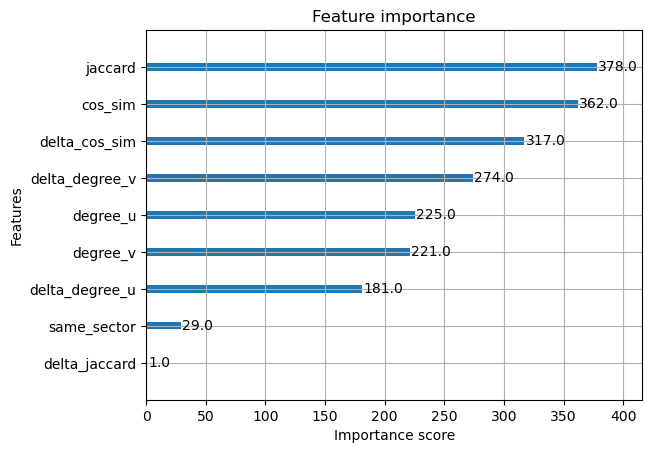

In [16]:
xgb.plot_importance(bst, max_num_features=10)

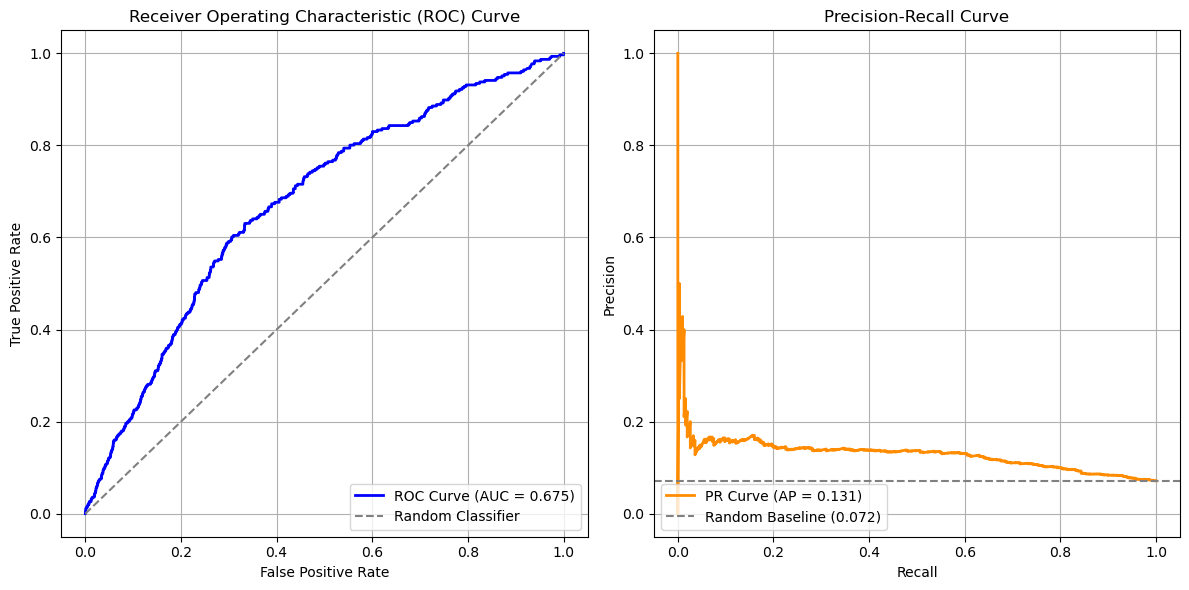

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

# Calculate the ROC curve points (False Positive Rate, True Positive Rate)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Calculate the Random Classifier Baseline
random_baseline = [0, 1]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

### ROC Plot (Left Subplot)
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc:.3f})')
axes[0].plot(random_baseline, random_baseline, linestyle='--', color='gray', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Calculate the PR curve points (Precision, Recall)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Calculate the Baseline Precision (fraction of positive cases)
baseline = y_test.sum() / len(y_test)

axes[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve (AP = {ap:.3f})')
axes[1].axhline(y=baseline, color='gray', linestyle='--', label=f'Random Baseline ({baseline:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [18]:
# Recompute edge sets for test source and target
edges_src_test = get_edge_set(src_test)
edges_dst_test = get_edge_set(dst_test)
new_edges_test = edges_dst_test - edges_src_test

df_test = df_test.copy()
df_test["proba"] = y_proba

# Candidate edges: not in src_test (i.e. could potentially be "new")
df_candidates = df_test[[ (u, v) not in edges_src_test for u, v in df_test[["u", "v"]].to_numpy() ]]

df_top = (
    df_candidates
    .sort_values("proba", ascending=False)
    .head(25)
)

df_top


,prev_window,src_window,dst_window,u,v,cos_sim,degree_u,degree_v,jaccard,same_sector,...,delta_degree_v,delta_jaccard,vol_norm_diff,mom_norm_diff,delta_vol_norm_u,delta_vol_norm_v,delta_mom_norm_u,delta_mom_norm_v,label,proba
1354,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,CTAS,DHI,0.893903,5.0,20.0,0.250000,0,...,13.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,1.153323
1513,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,DDOG,FSLR,0.887840,6.0,22.0,0.166667,1,...,18.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.955305
3648,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,NFLX,NOW,0.854098,3.0,18.0,0.166667,0,...,17.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.758472
971,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,CEG,ETN,0.814789,7.0,19.0,0.181818,0,...,17.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0.654114
239,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,ACN,NUE,0.864304,11.0,9.0,0.250000,0,...,8.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.422316
1510,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,DDOG,ETN,0.978519,6.0,19.0,0.190476,0,...,17.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0.339701
3378,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,MPC,MU,0.950994,9.0,25.0,0.214286,0,...,20.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0.209857
1001,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,CEG,NEM,0.782264,7.0,25.0,0.185185,0,...,22.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.167507
2409,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,HAL,MU,0.955219,7.0,25.0,0.185185,0,...,20.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.094283
2389,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,HAL,HOOD,0.840082,7.0,26.0,0.178571,0,...,18.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.053496


In [19]:
df_top[["u_sector", "u_industry"]] = df_top["u"].apply(lambda t: pd.Series(meta_lookup(t)))
df_top[["v_sector", "v_industry"]] = df_top["v"].apply(lambda t: pd.Series(meta_lookup(t)))

df_top

,prev_window,src_window,dst_window,u,v,cos_sim,degree_u,degree_v,jaccard,same_sector,...,delta_vol_norm_u,delta_vol_norm_v,delta_mom_norm_u,delta_mom_norm_v,label,proba,u_sector,u_industry,v_sector,v_industry
1354,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,CTAS,DHI,0.893903,5.0,20.0,0.250000,0,...,0.0,0.0,0.0,0.0,1,1.153323,Industrials,Specialty Business Services,Consumer Cyclical,Residential Construction
1513,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,DDOG,FSLR,0.887840,6.0,22.0,0.166667,1,...,0.0,0.0,0.0,0.0,0,0.955305,Technology,Software-Application,Technology,Solar
3648,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,NFLX,NOW,0.854098,3.0,18.0,0.166667,0,...,0.0,0.0,0.0,0.0,0,0.758472,Communication Services,Entertainment,Technology,Software-Application
971,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,CEG,ETN,0.814789,7.0,19.0,0.181818,0,...,0.0,0.0,0.0,0.0,1,0.654114,Utilities,Utilities-Independent Power Producers,Industrials,Specialty Industrial Machinery
239,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,ACN,NUE,0.864304,11.0,9.0,0.250000,0,...,0.0,0.0,0.0,0.0,0,0.422316,Technology,Information Technology Services,Basic Materials,Steel
1510,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,DDOG,ETN,0.978519,6.0,19.0,0.190476,0,...,0.0,0.0,0.0,0.0,1,0.339701,Technology,Software-Application,Industrials,Specialty Industrial Machinery
3378,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,MPC,MU,0.950994,9.0,25.0,0.214286,0,...,0.0,0.0,0.0,0.0,1,0.209857,Energy,Oil & Gas Refining & Marketing,Technology,Semiconductors
1001,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,CEG,NEM,0.782264,7.0,25.0,0.185185,0,...,0.0,0.0,0.0,0.0,0,0.167507,Utilities,Utilities-Independent Power Producers,Basic Materials,Gold
2409,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,HAL,MU,0.955219,7.0,25.0,0.185185,0,...,0.0,0.0,0.0,0.0,0,0.094283,Energy,Oil & Gas Equipment & Services,Technology,Semiconductors
2389,W_20251030_20251119,W_20251104_20251124,W_20251107_20251128,HAL,HOOD,0.840082,7.0,26.0,0.178571,0,...,0.0,0.0,0.0,0.0,0,0.053496,Energy,Oil & Gas Equipment & Services,Financial Services,Capital Markets
